# Supervised Learning: Support Vector Machines
## Case Study: Credit Card Fraud Detection

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

In this notebook we will work with a dataset that contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

For more information see: https://www.kaggle.com/mlg-ulb/creditcardfraud

### 1. Import the necessary packages

In [5]:
import pandas as pd 
import numpy as np

# Scikit-learn library for SVM
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix

from sklearn import svm

# Matplotlib library to plot the charts
import matplotlib.pyplot as plt

# Library for the statistic data vizualisation
import seaborn as sns
sns.set()


#### Helper functions

In [2]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### 2. Reading the credit card data

In [3]:
# Reading the file .csv
data = pd.read_csv('../../../Data/creditcard.csv') 
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


All of the columns starting with a V represent data from the given user that has been anonymized to protect the user's identity 

### 3. Exploring the data

Lets start by plotting the fraudulent amounts over time

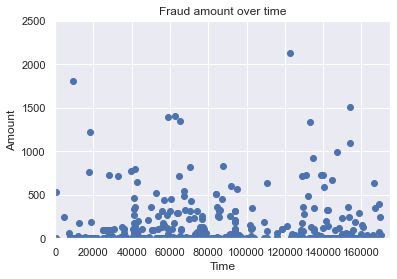

In [6]:
# Take the data of fraudulent transactions only
df_fraud = data[data['Class'] == 1]
plt.scatter(df_fraud['Time'], df_fraud['Amount']) # Display fraud amounts according to their time
plt.title('Fraud amount over time')
plt.xlabel('Time')
plt.ylabel('Amount')
plt.xlim([0,175000])
plt.ylim([0,2500])
plt.show()


We can se that most of the fraudulent transactions are done with relatively small amounts of money.

#### Getting the percentage of fraudulent transactions vs regular ones

In [7]:
number_fraud = len(data[data.Class == 1])
number_no_fraud = len(data[data.Class == 0])
print('The fraudulent transactions represent only %f percent of the transactions' % (number_fraud*100/(number_fraud+number_no_fraud)))

The fraudulent transactions represent only 0.172749 percent of the transactions


This dataset is unbalanced which means using the data as it is might result in unwanted behaviour from a supervised classifier i.e. the classifier can learn to predict everything as a real transaction and still get an accuracy of around 97 percent. 

There are many techniques to deal with unbalanced data sets but for now we will implement a technique known as **Random Under-Sampling** which consists of removing data in order to have a more balanced dataset and thus avoiding our models to overfitting. 

#### Random under-sampling

In [8]:
# Shuffle the data
data = data.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = data.loc[data['Class'] == 1]

non_fraud_df = data.loc[data['Class'] == 0][:fraud_df.shape[0]]

In [12]:
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

In [13]:
# Shuffle dataframe rows
balanced_data = normal_distributed_df.sample(frac=1, random_state=42)

balanced_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
128642,78788.0,-0.626221,0.541547,1.319281,-1.371560,-0.014254,-0.624565,0.390381,0.095534,-0.032101,...,-0.071037,-0.210570,0.051841,0.031207,-0.226194,0.718871,0.053605,0.038137,7.99,0
149357,91075.0,-1.855061,1.554964,-1.405809,0.669327,-0.280230,1.178652,-3.459979,-2.815155,1.242229,...,-0.095308,0.946629,-0.297403,-0.368344,0.198731,-0.078591,0.366709,0.073767,38.76,1
185369,126637.0,-4.261556,-3.941993,-0.789632,-2.606388,2.822660,2.728412,-0.168965,1.592447,0.250990,...,0.367567,-1.081691,0.947858,0.667717,0.596356,0.269440,-0.024696,-0.404474,489.50,0
123141,76826.0,-6.616293,3.563428,-7.058901,4.284346,-5.096299,-1.768618,-4.937554,2.748460,-3.796760,...,1.215976,0.041178,-1.059098,0.275662,0.057425,-0.265838,-0.514637,0.388590,254.76,1
79874,58217.0,-0.443794,1.271395,1.206178,0.790371,0.418935,-0.848376,0.917691,-0.235511,-0.285692,...,0.119279,0.513479,-0.264243,0.443311,0.029516,-0.335141,-0.188815,-0.123391,5.09,1


In [15]:
balanced_data.shape

(984, 31)

### 3. Processing the data for the model

 #### Separating the data into predictors and targets

In [16]:
# We will take every column concerning the user data and the Amount, and will
# discard the time
X = balanced_data[balanced_data.columns[1:-1]].copy()
y = balanced_data['Class']

#### Cross validation: split the data into train and test set

Cross validation is a commonly used process by which a method that works for one sample of a population is checked for validity by applying the method to another sample from the same population.

In [20]:
# we will use a test size of .25 meaning that 75% of the data will be used to train and 25% to test the model
# the two sets are mutually exclusive
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### 3. Training the Support Vector Machine classifier

#### Defining the model

Witht the implementation of sklearn we can use the argument kernel to specify the kernel type to be used in the algorithm.

_It must be one of ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ or a callable. If none is given, ‘rbf’ will be used. If a callable is given it is used to pre-compute the kernel matrix from data matrices; that matrix should be an array of shape (n_samples, n_samples)._

In [21]:
# We define a model using a Polynomial kernel
model = svm.SVC(kernel='poly')

#### Fit the model to the training data

In [22]:
model.fit(X_train, y_train)

SVC(kernel='poly')

### 4. Use and evaluate the model

#### Now that our model is succesfully trained, we can use it to predict fraudulent transactions

In [23]:
predictions = model.predict(X_test)

#### Lets see how well our model performs on the test data.

To have a look at the model's performance we plot its **Confusion Matrix**. A confusion matrix is a summary of prediction results on a classification problem. The number of correct and incorrect predictions are summarized with count values and broken down by each class. The confusion matrix shows the ways in which your classification model is confused when it makes predictions. It gives us insight not only into the errors being made by a classifier but more importantly the types of errors that are being made.

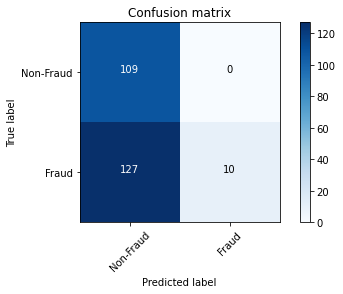

In [92]:
class_names = np.array(['Non-Fraud','Fraud'])
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, class_names)

We can observe that our model is **correctly identifying all of the non-fraud transactions** (not a single non-fraud predicted as fraus). However, our model still misses most of the fraudulent transactions predicting them as non-fraud.

### 5. Try to improve the model

There are many ways in which we could improve the model. Lets try to change the kernel in our classifier

In [93]:
# We define a model using a Polynomial kernel
model = svm.SVC(kernel='linear')

# Fit the model to the data
model.fit(X_train, y_train)

SVC(kernel='linear')

#### Evaluate the new model

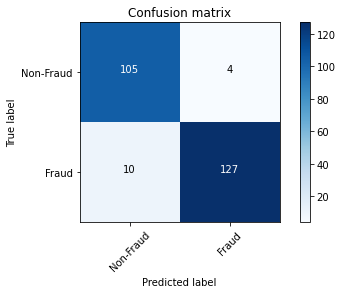

In [95]:
predictions = model.predict(X_test)

class_names=np.array(['Non-Fraud','Fraud'])
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, class_names)

The model is looking way better now, however it still missed 10 fraudulent transactions and misclassified 4 non-fraud transactions as fraud. **How do you think we can improve the model?**